In [1]:
import numpy as np
import matplotlib.pyplot as plt
import datetime # using this to tell how long a simulation run takes
import time # using this to tell how long a simulation run takes
import matplotlib.animation as animation

from time import process_time
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

## Explicit finite difference scheme

### Rewriting equation in terms of row (position) and column (time) indicies.

The equation (Eq. 4.0 in doc) given to me by Jack is: 

\begin{equation}
E^{n+1}_i = \left ( \frac{\Delta t}{\Delta x} \frac{c}{n} \right )^2 (E^{n}_{i+1} - 2E^{n}_{i} + E^{n}_{i-1})-(-2E^{n}_{i} + E^{n-1}_{i})
\end{equation}

where $ \displaystyle r = \left ( \frac{\Delta t}{\Delta x} \frac{c}{n} \right )^2 $ and n is the position index and i is the time index (dimensionless)

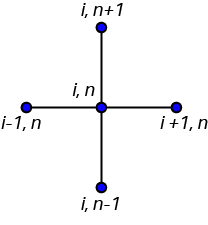

Using the image above, we use [i,n] ; [i-1,n] ; [i+1,n] ; [i, n-1] and take a weighted average to find [i,n+1].

### Defining parameters needed to solve differential equation: $ \nabla^{2} E - \frac{n^2}{c^2} \frac{\partial^2 E}{\partial t^{2}} = 0$

In [2]:
# Unit conversions
ps = 10**-12    # picoseconds unit
nm = 10**-9     # nanometers unit
um = 10 ** -6   # micrometer unit
    
# Physical parameters
RefractiveIndex = 1                         # unitless
speed_of_light = 299792458                  # in m/s
wavelength = 351 * nm # we choose wavelength

# time-step size “dt” is strictly controlled by Courant–Friedrichs–Lewy (CFL) condition 
#so that the wave propagation distance within a allowed time-step size cannot exceed the grid size “dx”.
CFL = 0.5
delta_x = 0.05 * wavelength
delta_t = CFL * delta_x / speed_of_light    # time related time-step

# Physics formulas
frequency = speed_of_light/wavelength       # in Hertz
angular_frequency = 2 * np.pi * frequency   # in Hertz
wavenumber = (2 * np.pi) / wavelength       # wave number 'k' will be imaginary part in the coming days (when we do it correctly)
period = wavelength / speed_of_light        # wave period (can also be calculated with 1/f)

# Grid and time parameters
lambda_mult = 10  # represents number of cycles
T = lambda_mult * period # modeling time
n_timestep = int(T/delta_t)        # n time step

L = wavelength * lambda_mult
n_cells = int(L/delta_x)            # number of cells (can also think of as number of grid points)

### Initializing laser intensity and electric field

In [3]:
R = 25 * um # radius of laser
E_L = 10 * (10 ** -6) # in joules laser energy (10 mu joules)
Area_L = np.pi * R **2 # area of laser
T_laser = 100 * ps # laser pulse time
I_0 = E_L / (Area_L * T_laser) # laser intensities (SI unit is Joules/(m**2) * s )
permittivity_free_space = 8.85418782 * 10 **-12

# Electric field (same as before but now using complex refractive index)
E_0 = np.sqrt( (2 * I_0) / (speed_of_light * RefractiveIndex * permittivity_free_space)) # SI unit is voltage / m

# Laser intensity
I_0 = E_L / (Area_L * T_laser) # laser intensities (SI unit is Joules/(m**2) * s )

## Modeling the damping wave

In [4]:
# defining complex index of refraction (no imaginary yet)
n_r = 1
n_i = 0.0
complex_refractive_index = complex(n_r, n_i)
complex_wavenumber = (angular_frequency / speed_of_light) * complex_refractive_index

In [5]:
# Start the stopwatch / counter 
start = time.time()

x = []  # spatial domain (can also think of as coordinates of grid points)
t = []  # time domain

# Creating arrays for the spatial and time domains. Starting at -2 in order to create ghost cells. And ending with + 3 for the same reason
# The ghost cells are there so that in the matrix we can access all indeces
# To append, using formula Dr. Woo gave me: X_i = delta_x(i + 1/2)
for i in range(-2, n_cells + 3):
    x.append(delta_x * (i + 0.5))

for i in range(-2, n_timestep + 3):
    t.append(delta_t * (i + 0.5))
    
x = np.array(x)
t = np.array(t)

E_complex = 1j * np.zeros((len(t), len(x))) # initializing imaginary matrix of dimensions (t, x)
# S_xt = 1j * np.zeros((len(t), len(x)))

r_const_complex = ( (delta_t/delta_x) * (speed_of_light/complex_refractive_index) ) ** 2 # our parameter

# These loops will go through the grid. We start at 1 so as to not calculate the
# value when the a time or spatial point is equal to 0.
index = 0
for n in range(1, (len(t) - 3)*1 + 0):
    t_sim = t[n] # in seconds
    
    # Defning cos and sin terms for wave to later be turned into complex numbers for t_nm1
    # Making sin zero because it is imaginary component
    cos_term_0_t_nm1 = E_0 * np.cos((wavenumber * x[0]) - (angular_frequency * t[n-1]) + np.pi/2)
    sin_term_0_t_nm1 = 0
    
    cos_term_1_t_nm1 = E_0 * np.cos((wavenumber * x[1]) - (angular_frequency * t[n-1]) + np.pi/2)
    sin_term_1_t_nm1 = 0
    
    # Initial conditions in time:
    E_complex[n-1, 0] = complex(cos_term_0_t_nm1, sin_term_0_t_nm1)
    E_complex[n-1, 1] = complex(cos_term_1_t_nm1, sin_term_1_t_nm1)
    
    
    # Defning cos and sin terms for wave to later be turned into complex numbers for t_n
    # Making sin zero because it is imaginary component
    cos_term_0_t_n = E_0 * np.cos((wavenumber * x[0]) - (angular_frequency * t[n]) + np.pi/2)
    sin_term_0_t_n = 0
    
    cos_term_1_t_n = E_0 * np.cos((wavenumber * x[1]) - (angular_frequency * t[n]) + np.pi/2)
    sin_term_1_t_n = 0
    
    # Instantenously defining the boundary conditions/values of ghost cells on the RIGHT:
    E_complex[n, 0] = complex(cos_term_0_t_n, sin_term_0_t_n)
    E_complex[n, 1] = complex(cos_term_1_t_n, sin_term_1_t_n)
    
    # We have no laser on the left, so boundary conditions are just 0
    E_complex[n, -1] = complex(0)
    E_complex[n, -2] = complex(0)
    
    precision_num = 10
    for i in range(2, len(x) - 3):
        
        # explicit scheme
        E_complex[n+1, i] = np.exp(-complex_wavenumber.imag * x[i]) * ( (r_const_complex.real) * ( E_complex[n, i+1] - 2*E_complex[n, i] + E_complex[n, i-1] ) - ( -2*E_complex[n, i] + E_complex[n-1, i] ) )
        
        # this if block constrains the wave to inside our physical bounds
        if (True) and abs(E_complex[n+1, i])/abs(E_0) > 1:
            E_complex[n+1, i] = E_0 * np.sign(E_complex[n, i])
    
        index += 1
        
# Stop the stopwatch / counter
end = time.time()
   
print("Elapsed time:", end, start) 
print("Elapsed time during the whole program in minutes:", datetime.timedelta(seconds = (end - start))) 

Elapsed time: 1689579510.4807627 1689579510.3589988
Elapsed time during the whole program in minutes: 0:00:00.121764


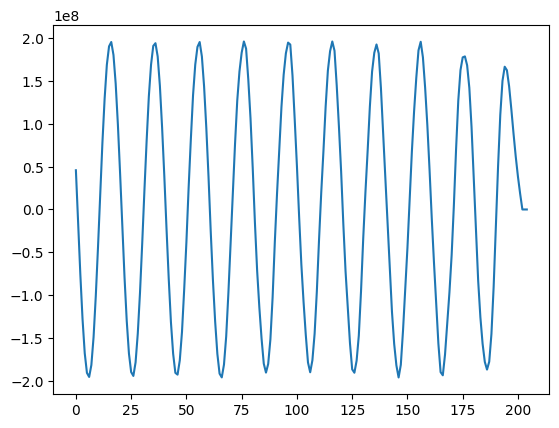

In [7]:
plt.plot(E_complex[int(int(E_complex.shape[0]/lambda_mult) * lambda_mult), :].real)

In [ ]:
# np.save(f"E_complex_{lambda_mult}_cycles", E_complex)
# np.save(f"E_complex_{lambda_mult}_cycles_xdata", x)
# np.save(f"E_complex_{lambda_mult}_cycles_tdata", t)
# E_complex_10_cycles_data = np.load("E_complex_10_cycles.npy")
# E_complex_10_cycles_xdata = np.load("E_complex_10_cycles_xdata.npy")
# E_complex_10_cycles_tdata = np.load("E_complex_10_cycles_tdata.npy")

In [ ]:
plt.plot(E_complex_10_cycles_data[int(9999 * lambda_mult), :].real)

In [ ]:
# re-defining complex index of refraction (adding imaginary part to force damping using analytical solution)
n_r = 1
n_i = 0.125
complex_refractive_index = complex(n_r, n_i)
complex_wavenumber = (angular_frequency / speed_of_light) * complex_refractive_index

In [ ]:
format_title = "{} cycles complex".format(lambda_mult)
plt.title(format_title)
plt.xlabel("Number of grid points in system (nm)") # in entire simulation domain. Units of 10 ** -9 meters in SI units
plt.ylabel("Electric field amplitude (V/m)") # SI unit of volts / m
# plt.plot(np.exp(-complex_wavenumber.imag * x) * E_complex[int(int(E_complex.shape[0]/lambda_mult) * lambda_mult), :].real)
plt.plot(np.exp(-complex_wavenumber.imag * x) * E_complex[200, :].real)
# plt.plot(np.exp(-complex_wavenumber.imag * E_complex_10_cycles_xdata) * E_complex_10_cycles_data[int(9999 * lambda_mult), :].real)
# plt.legend(["real: {} * λ".format(lambda_mult), "complex: {} * λ".format(lambda_mult)])
# plt.savefig('{}_times_lambda.png'.format(lambda_mult))
plt.show()

In [ ]:
plt.plot(np.exp(-complex_wavenumber.imag * x))
plt.ylabel("Absorption coefficient (unitless)")
plt.xlabel("Position in nm")
plt.show()

In [ ]:
# laser_intensity = S_xt / (-2 * complex_wavenumber)
laser_intensity = (speed_of_light * n_r * permittivity_free_space)/2 * (E_complex.real)**2

In [ ]:
S_xt_ = -2 * complex_wavenumber * laser_intensity

In [ ]:
plt.plot(x, laser_intensity[400,:])
plt.title("Plot of Laser Intensity '$I$' over space")
plt.xlabel("Space (x)")
plt.ylabel("Laser Intensity")
plt.show()